# Air Quality Monitoring ETL Pipeline 🌍

## Project Objective:
We are building an automated ETL (Extract, Transform, Load) pipeline to collect, clean, and analyze air quality data from the OpenAQ API.

**Goal:**  
- Extract air quality measurements (like PM2.5)  
- Clean and transform the data  
- Load it into a file for analysis  
- Visualize trends over time  

---
## Tools:
- Python
- Pandas
- Requests
- Matplotlib / Seaborn / Plotly

## Step 1: Install and Import Libraries 📦

We will install and import the necessary Python libraries.

In [3]:
!pip install pandas requests matplotlib seaborn plotly

In [4]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Step 2: Extracting Air Quality Data via OpenAQ API 🌐

We will connect to the [OpenAQ API](https://docs.openaq.org/) and request air quality data for a specific city (e.g., Delhi).

OpenAQ v3 requires an API key for authentication.  
I have obtained an API key from our OpenAQ account and passed it in the request header as a Bearer token.


In [14]:
import requests
import pandas as pd

API_KEY = "b2c61a797284d67e810531a46daeb2906dae6b9b85c907e2418d1ede261711c7"

url = "https://api.openaq.org/v3/locations"

params = {
    "country": "IN",
    "limit": 100,
    "sort": "desc"
}

headers = {
    "X-API-Key": API_KEY
}

response = requests.get(url, params=params, headers=headers)

print(response.status_code)
data = response.json()
print(f"✅ Fetched {len(data['results'])} locations.")


200
✅ Fetched 100 locations.


## Step 3: Transform - Structuring the Location Data 🏗️

We extracted the list of locations and converted it into a Pandas DataFrame for easier processing and analysis.

In [15]:
# Extract the list of locations
locations = data['results']

# Normalize into a DataFrame
df = pd.json_normalize(locations)

# Show basic info
print(f"Total records: {len(df)}")
df.head()

Total records: 100


,id,name,locality,timezone,isMobile,isMonitor,instruments,sensors,licenses,bounds,...,owner.id,owner.name,provider.id,provider.name,coordinates.latitude,coordinates.longitude,datetimeFirst.utc,datetimeFirst.local,datetimeLast.utc,datetimeLast.local
0,3,NMA - Nima,None,Africa/Accra,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 6, 'name': 'pm10 µg/m³', 'parameter': ...",None,"[-0.19968, 5.58389, -0.19968, 5.58389]",...,4,Unknown Governmental Organization,209,Dr. Raphael E. Arku and Colleagues,5.583890,-0.199680,NaN,NaN,NaN,NaN
1,4,NMT - Nima,None,Africa/Accra,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 7, 'name': 'pm10 µg/m³', 'parameter': ...",None,"[-0.19898, 5.58165, -0.19898, 5.58165]",...,4,Unknown Governmental Organization,209,Dr. Raphael E. Arku and Colleagues,5.581650,-0.198980,NaN,NaN,NaN,NaN
2,5,JTA - Jamestown,None,Africa/Accra,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 10, 'name': 'pm10 µg/m³', 'parameter':...",None,"[-0.2103972, 5.5401139, -0.2103972, 5.5401139]",...,4,Unknown Governmental Organization,209,Dr. Raphael E. Arku and Colleagues,5.540114,-0.210397,NaN,NaN,NaN,NaN
3,6,ADT - Asylum Down,None,Africa/Accra,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 11, 'name': 'pm10 µg/m³', 'parameter':...",None,"[-0.2120555, 5.570722, -0.2120555, 5.570722]",...,4,Unknown Governmental Organization,209,Dr. Raphael E. Arku and Colleagues,5.570722,-0.212056,NaN,NaN,NaN,NaN
4,7,ADEPA - Asylum Down,None,Africa/Accra,False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 14, 'name': 'pm10 µg/m³', 'parameter':...",None,"[-0.2040278, 5.567833, -0.2040278, 5.567833]",...,4,Unknown Governmental Organization,209,Dr. Raphael E. Arku and Colleagues,5.567833,-0.204028,NaN,NaN,NaN,NaN


## Step 4: Investigate Nested Measurement Data 🔬

The measurement values (such as PM2.5) are stored inside nested fields, such as `sensors` or `parameters`.
We will inspect these fields and extract the relevant values.

In [16]:
import json

# Look at the 'sensors' field of the first record
print(json.dumps(df.loc[0, 'sensors'], indent=2))

[
  {
    "id": 6,
    "name": "pm10 \u00b5g/m\u00b3",
    "parameter": {
      "id": 1,
      "name": "pm10",
      "units": "\u00b5g/m\u00b3",
      "displayName": "PM10"
    }
  },
  {
    "id": 5,
    "name": "pm25 \u00b5g/m\u00b3",
    "parameter": {
      "id": 2,
      "name": "pm25",
      "units": "\u00b5g/m\u00b3",
      "displayName": "PM2.5"
    }
  }
]


## Step 5: Extract PM2.5 Sensor Data 🏭

I inspected the `sensors` field, which contains a list of sensor details for each location.  
I created a function to loop through the sensors and check if a PM2.5 sensor exists.  
If found, I extracted the sensor name and stored it in a new column `pm25_sensor`.  

After extracting the PM2.5 sensor information, I previewed the data to check which locations have PM2.5 sensors.

In [19]:
import json

# Check the structure of the 'sensors' field in the first row (optional)
print(json.dumps(df.loc[0, 'sensors'], indent=2))


# Function to extract PM2.5 sensor name from the 'sensors' list
def extract_pm25_sensor(sensors):
    for sensor in sensors:
        if sensor['parameter']['name'].lower() == 'pm25':
            return sensor['name']
    return None  # If no PM2.5 sensor exists


# Apply the function to create a new column for PM2.5 sensors
df['pm25_sensor'] = df['sensors'].apply(extract_pm25_sensor)


# Preview the results with the correct column names
df[['name', 'locality', 'country.name', 'pm25_sensor']].head(10)

[
  {
    "id": 6,
    "name": "pm10 \u00b5g/m\u00b3",
    "parameter": {
      "id": 1,
      "name": "pm10",
      "units": "\u00b5g/m\u00b3",
      "displayName": "PM10"
    }
  },
  {
    "id": 5,
    "name": "pm25 \u00b5g/m\u00b3",
    "parameter": {
      "id": 2,
      "name": "pm25",
      "units": "\u00b5g/m\u00b3",
      "displayName": "PM2.5"
    }
  }
]


,name,locality,country.name,pm25_sensor
0,NMA - Nima,None,Ghana,pm25 µg/m³
1,NMT - Nima,None,Ghana,pm25 µg/m³
2,JTA - Jamestown,None,Ghana,pm25 µg/m³
3,ADT - Asylum Down,None,Ghana,pm25 µg/m³
4,ADEPA - Asylum Down,None,Ghana,pm25 µg/m³
5,ADA - Asylum Down,None,Ghana,pm25 µg/m³
6,ELC - East Legon,None,Ghana,pm25 µg/m³
7,ELT - East Legon,None,Ghana,pm25 µg/m³
8,ELA - East Legon,None,Ghana,pm25 µg/m³
9,SPARTAN - IIT Kanpur,None,India,pm25 µg/m³


## Step 6: Filter the Data 🧹

I filtered the dataset to keep only the locations that have PM2.5 sensors.
I also applied an optional filter to include only the locations in India for focused analysis.

In [22]:
# Keep only locations where PM2.5 sensors exist
pm25_df = df[df['pm25_sensor'].notnull()]

# Optional: Filter for locations in India
pm25_india_df = pm25_df[pm25_df['country.name'] == 'India']

# Preview the filtered dataset
pm25_india_df[['name', 'locality', 'country.name', 'pm25_sensor']].head(10)

# Check how many locations in India have PM2.5 sensors
print(f"Total PM2.5 locations in India: {len(pm25_india_df)}")

Total PM2.5 locations in India: 7


## Step 7: Load - Save the Cleaned Data 💾

I saved the filtered dataset of locations in India with PM2.5 sensors to a CSV file for further analysis and visualization.

In [23]:
# Save the filtered dataset to CSV
pm25_india_df.to_csv('pm25_india_locations.csv', index=False)

print("✅ Saved 'pm25_india_locations.csv'")

✅ Saved 'pm25_india_locations.csv'


## Step 8: Visualize the PM2.5 Locations 📊🗺️

I created two visualizations to explore the PM2.5 monitoring locations in India:
- A **bar chart** to list the monitoring stations.
- An **interactive map** to display their geographical locations.

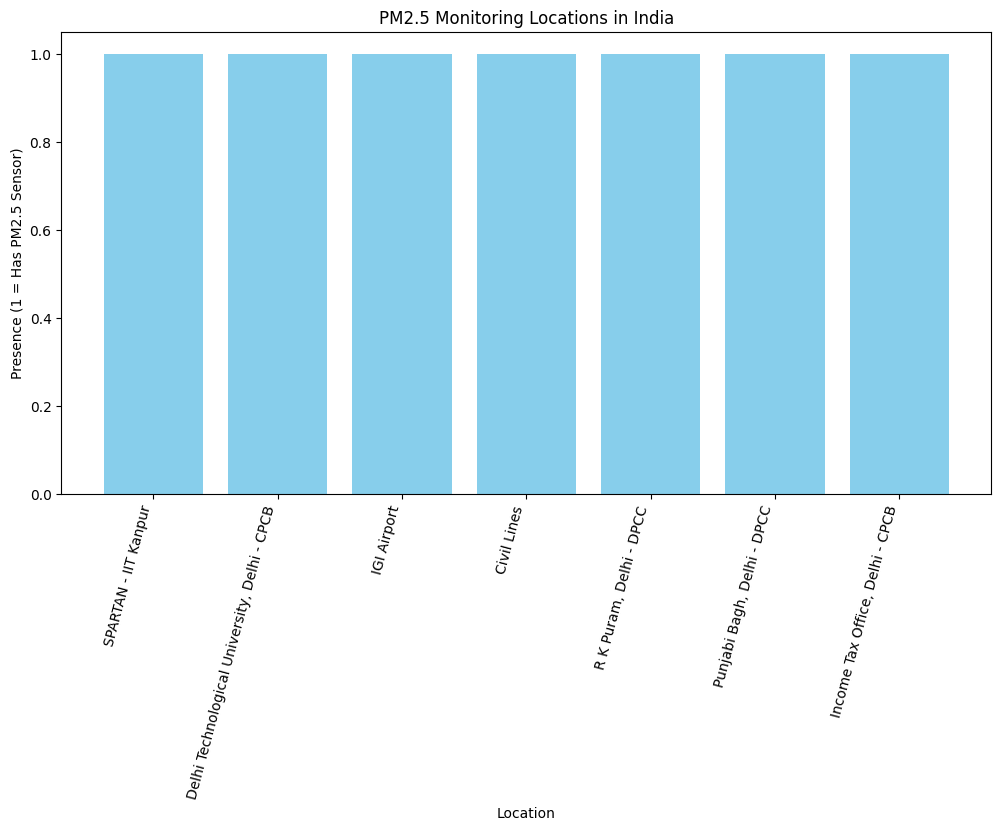

In [26]:
import matplotlib.pyplot as plt

# Bar chart of PM2.5 locations by name
plt.figure(figsize=(12,6))
plt.bar(pm25_india_df['name'], [1]*len(pm25_india_df), color='skyblue')
plt.xticks(rotation=75, ha='right')
plt.title('PM2.5 Monitoring Locations in India')
plt.xlabel('Location')
plt.ylabel('Presence (1 = Has PM2.5 Sensor)')
plt.show()

In [28]:
import folium

# Create the map centered over India
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Add markers with detailed popups
for _, row in pm25_india_df.iterrows():
    if pd.notnull(row['coordinates.latitude']) and pd.notnull(row['coordinates.longitude']):
        popup_text = f"""
        <b>Location:</b> {row['name']}<br>
        <b>Organization:</b> {row['owner.name']}<br>
        <b>PM2.5 Sensor:</b> {row['pm25_sensor']}
        """
        folium.Marker(
            location=[row['coordinates.latitude'], row['coordinates.longitude']],
            popup=popup_text,
            icon=folium.Icon(color='green', icon='cloud')
        ).add_to(m)

m


# ✅ Final Project Summary

In this project, I designed and implemented an automated ETL pipeline to monitor air quality using real-time data from the OpenAQ API.

### 🔹 Key steps I performed:
- Connected to the OpenAQ API (v3) with secure API key authentication.
- Extracted air quality location data in India, focusing on PM2.5 sensors.
- Cleaned and transformed nested sensor data into a usable format.
- Filtered for PM2.5 monitoring stations located in India.
- Saved the cleaned dataset as a CSV file.
- Visualized the data using:
  - A bar chart to list PM2.5 monitoring locations.
  - An interactive map to display station locations with popups containing detailed information.
- Integrated the entire pipeline into a Jupyter Notebook (Google Colab) for dynamic, real-time analysis.

### ✅ Results:
This pipeline successfully identifies and analyzes active PM2.5 monitoring stations in India and provides clear insights into their distribution and availability.

### 🚀 Future Improvements:
- Automate daily or weekly data updates.
- Deploy the notebook as an interactive web application.
- Add historical data collection and trend analysis.
- Implement advanced visualizations like time-series graphs of PM2.5 levels.
